# Overview

In this playground competition, we are provided with the challenge of predicting total sales for every product and store in the next month for Russian Software company-1c company.

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

### Data fields description:
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* date - date in format dd/mm/yyyy
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category


# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm


from matplotlib import rcParams
from typing import List
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.seasonal import DecomposeResult

import utils

# Load Data

In [2]:
train_df, test_df = utils.load_data()
train_df = utils.add_features(train_df)

In [3]:
train_df.shape

(2935849, 15)

In [4]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part
49800,2013-01-01,0,18,5823,2500.0,1.0,Playstation Store пополнение бумажника: Карта ...,35,Карты оплаты - PSN,"Красноярск ТЦ ""Июнь""",красноярск,11,56.01839,92.86717,4
29784,2013-01-01,0,27,5573,849.0,1.0,PS Move Motion Controller Charger (Зарядная ст...,2,Аксессуары - PS3,"Москва ТЦ ""МЕГА Белая Дача II""",москва,13,55.75222,37.61556,1
35476,2013-01-01,0,7,1006,399.0,1.0,3D Crystal Puzzle Дельфин XL,67,Подарки - Развитие,"Воронеж ТРЦ ""Максимир""",воронеж,4,51.67204,39.18430,3
8330,2013-01-01,0,19,17707,899.0,1.0,Праздник спорта (Essentials) (только для PS Mo...,19,Игры - PS3,"Курск ТЦ ""Пушкинский""",курск,12,51.73733,36.18735,3
57384,2013-01-01,0,14,19548,149.0,1.0,ТАКИЕ РАЗНЫЕ БЛИЗНЕЦЫ (регион),40,Кино - DVD,"Казань ТЦ ""ПаркХаус"" II",казань,8,55.78874,49.12214,4


In [5]:
print(f"Starting date: {train_df['date'].min()}")
print(f"Ending date: {train_df['date'].max()}")
print(f"Number of months: {len(train_df['date_block_num'].unique())}")

Starting date: 2013-01-01 00:00:00
Ending date: 2015-10-31 00:00:00
Number of months: 34


November 2015 & December 2015 are missing.

In [6]:
print(f"Number of shops: {len(train_df['shop_id'].unique())}")
print(f"Number of items: {len(train_df['item_id'].unique())}")
print(f"Number of categories: {len(train_df['item_category_id'].unique())}")

Number of shops: 60
Number of items: 21807
Number of categories: 84


In [7]:
train_df[["item_price","item_cnt_day"]].describe() 

,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06
mean,8.908532e+02,1.242641e+00
std,1.729800e+03,2.618834e+00
min,-1.000000e+00,-2.200000e+01
25%,2.490000e+02,1.000000e+00
50%,3.990000e+02,1.000000e+00
75%,9.990000e+02,1.000000e+00
max,3.079800e+05,2.169000e+03


In [8]:
print("Are there any missing values?")
train_df.isna().sum()

Are there any missing values?


date                  0
date_block_num        0
shop_id               0
item_id               0
item_price            0
item_cnt_day          0
item_name             0
item_category_id      0
item_category_name    0
shop_name             0
city_name             0
city_id               0
city_coord_1          0
city_coord_2          0
country_part          0
dtype: int64

We can see that the data is already cleaned.

In [9]:
test_df.shape

(214200, 8)

In [10]:
test_df.head()

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name,item_cnt_month
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",NaN
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",NaN
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",NaN
3,3,5,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад""",NaN
4,4,5,5268,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад""",NaN


In [11]:
print(f"Number of shops: {len(test_df['shop_id'].unique())}")
print(f"Number of items: {len(test_df['item_id'].unique())}")
print(f"Number of categories: {len(test_df['item_category_id'].unique())}")

Number of shops: 42
Number of items: 5100
Number of categories: 62


In [12]:
print("Are there any missing values?")
test_df.isna().sum()

Are there any missing values?


ID                         0
shop_id                    0
item_id                    0
item_name                  0
item_category_id           0
item_category_name         0
shop_name                  0
item_cnt_month        214200
dtype: int64

# Is Any Item Sold Twice in a Single Day?

In [13]:
df = train_df.groupby(["date", "shop_id", "item_id"]).count()["item_cnt_day"]
df[df > 1]

date        shop_id  item_id
2013-01-05  54       20130      2
2013-01-25  31       14050      2
2013-01-27  38       15702      2
2013-01-29  25       12133      2
2013-02-16  25       12133      2
2013-02-18  16       15702      2
2013-03-02  16       12133      2
2013-03-07  50       12133      2
2013-04-06  54       14050      2
2013-12-28  54       12133      2
2013-12-29  27       12133      2
2014-02-23  50       3423       2
2014-03-09  31       12133      2
2014-03-23  21       3423       2
2014-03-30  31       16875      2
2014-05-01  50       3423       2
2014-07-12  25       3423       2
2014-08-14  31       9842       2
2014-08-16  56       16587      2
2014-11-21  31       16587      2
2014-12-22  31       8237       2
2014-12-26  17       3424       2
2014-12-31  42       21619      2
            57       8237       2
2015-02-12  42       21619      2
2015-02-17  5        21619      2
2015-02-21  25       16587      2
2015-10-07  12       21619      2
Name: item_cnt_day,

In [14]:
query_datetime = pd.to_datetime("2013-01-05", format="%Y-%m-%d")
df = train_df[train_df["date"] == query_datetime]
df.query(f"shop_id == 54 and item_id == 20130")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part
76961,2013-01-05,0,54,20130,149.0,1.0,УЧЕНИК ЧАРОДЕЯ (регион),40,Кино - DVD,"Химки ТЦ ""Мега""",химки,26,55.89704,37.42969,1
76962,2013-01-05,0,54,20130,149.0,1.0,УЧЕНИК ЧАРОДЕЯ (регион),40,Кино - DVD,"Химки ТЦ ""Мега""",химки,26,55.89704,37.42969,1


In [15]:
query_datetime = pd.to_datetime("2013-01-29", format="%Y-%m-%d")
df = train_df[train_df["date"] == query_datetime]
df.query(f"shop_id == 25 and item_id == 12133")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part
6959,2013-01-29,0,25,12133,889.0,1.0,Игровой набор с микророботами Вориорз для поед...,62,"Подарки - Гаджеты, роботы, спорт","Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1
6960,2013-01-29,0,25,12133,1389.0,1.0,Игровой набор с микророботами Вориорз для поед...,62,"Подарки - Гаджеты, роботы, спорт","Москва ТРК ""Атриум""",москва,13,55.75222,37.61556,1


In [16]:
query_datetime = pd.to_datetime("2015-02-12", format="%Y-%m-%d")
df = train_df[train_df["date"] == query_datetime]
df.query(f"shop_id == 42 and item_id == 21619")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part
2420539,2015-02-12,25,42,21619,499.00,1.0,ЧЕЛОВЕК ДОЖДЯ (BD),37,Кино - Blu-Ray,"СПб ТК ""Невский Центр""",спб,21,59.93863,30.31413,2
2420538,2015-02-12,25,42,21619,465.05,1.0,ЧЕЛОВЕК ДОЖДЯ (BD),37,Кино - Blu-Ray,"СПб ТК ""Невский Центр""",спб,21,59.93863,30.31413,2


In [17]:
query_datetime = pd.to_datetime("2015-10-07", format="%Y-%m-%d")
df = train_df[train_df["date"] == query_datetime]
df.query(f"shop_id == 12 and item_id == 21619")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part
2909372,2015-10-07,33,12,21619,399.0,1.0,ЧЕЛОВЕК ДОЖДЯ (BD),37,Кино - Blu-Ray,Интернет-магазин ЧС,интернет-магазин,7,0.0,0.0,0
2909373,2015-10-07,33,12,21619,499.0,1.0,ЧЕЛОВЕК ДОЖДЯ (BD),37,Кино - Blu-Ray,Интернет-магазин ЧС,интернет-магазин,7,0.0,0.0,0


It seems that some `items have multiple transactions` in the same shop and date, but with a different `item_price`.

# Outliers

In [18]:
def detect_outliers(df: pd.DataFrame):
    df = df.copy()
    
    axes = None
    _, axes = plt.subplots(2,2, figsize=(10,5), constrained_layout=True)
    axes[0, 0].set_title("Before Removing Outliers (Prices)")
    axes[1, 0].set_title("Before Removing Outliers (Sales)")
    sns.boxplot(x=df["item_price"], ax=axes[0, 0])
    sns.boxplot(x=df["item_cnt_day"], ax=axes[1, 0])
    
    # Drop training items with extreme or negative prices or sales counts
    df = df[(df["item_price"] > 0) & (df["item_price"] < 50000)]
    df = df[(df["item_cnt_day"] > 0) & (df["item_cnt_day"] < 1000)]
    
    axes[0, 1].set_title("After Removing Outliers (Prices)")
    axes[1, 1].set_title("After Removing Outliers (Sales)")
    sns.boxplot(x=df["item_price"], ax=axes[0, 1])
    sns.boxplot(x=df["item_cnt_day"], ax=axes[1, 1])
    plt.show()

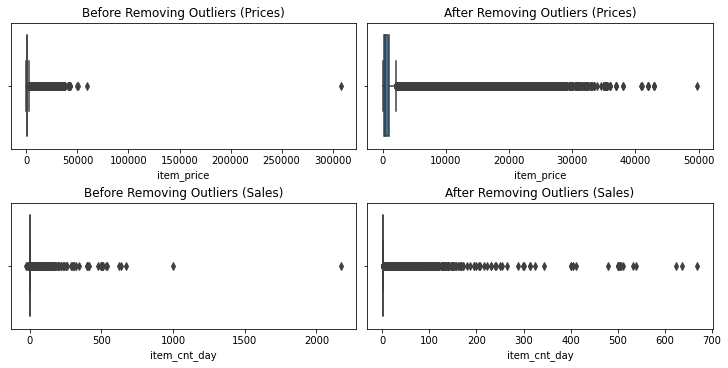

In [19]:
detect_outliers(train_df)

# Preprocess

## Detect Same Shops

In [20]:
def get_shop_name(df: pd.DataFrame, shop_id: int) -> str:
    row = df[df["shop_id"] == shop_id].iloc[0]
    
    return row["shop_name"]

In [21]:
print(get_shop_name(train_df, shop_id=0))
print(get_shop_name(train_df, shop_id=57))

!Якутск Орджоникидзе, 56 фран
Якутск Орджоникидзе, 56


In [22]:
print(get_shop_name(train_df, shop_id=1))
print(get_shop_name(train_df, shop_id=58))

!Якутск ТЦ "Центральный" фран
Якутск ТЦ "Центральный"


In [23]:
print(get_shop_name(train_df, shop_id=10))
print(get_shop_name(train_df, shop_id=11))

Жуковский ул. Чкалова 39м?
Жуковский ул. Чкалова 39м²


In [24]:
print(get_shop_name(train_df, shop_id=40))
print(get_shop_name(train_df, shop_id=39))

РостовНаДону ТРК "Мегацентр Горизонт" Островной
РостовНаДону ТРК "Мегацентр Горизонт"


### Replace shop_id

In [25]:
train_df["shop_id"] = train_df["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
test_df["shop_id"] = test_df["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})

Let's see how many unique shops we have now:

In [26]:
print(f"Number of shops in train_split: {len(train_df['shop_id'].unique())} (before = 60)")
print(f"Number of shops in test_split: {len(test_df['shop_id'].unique())} (before = 42)")

Number of shops in train_split: 56 (before = 60)
Number of shops in test_split: 42 (before = 42)


We can observe that those shops were not even present in the test split.

## Add Revenue Features

In [27]:
train_df["item_revenue"] = train_df["item_cnt_day"] * train_df["item_price"]

## Aggregate Data into Months

In [28]:
train_monthly_df_group = train_df.groupby(["date_block_num", "city_id", "shop_id", "item_category_id", "item_id"], as_index=False)
train_monthly_df = train_monthly_df_group.agg({"item_price": ["mean"], "item_cnt_day": ["sum", "mean", "count"], "item_revenue": ["sum"]})

In [29]:
train_monthly_df.head()

date_block_num city_id shop_id item_category_id item_id   item_price  \
                                                                  mean   
0              0       0       2                2    5572  1532.857143   
1              0       0       2                2    5573   924.000000   
2              0       0       2                2    5575   955.005000   
3              0       0       2                2    5576  2490.000000   
4              0       0       2                2    5632  2390.000000   

  item_cnt_day                 item_revenue  
           sum      mean count          sum  
0          9.0  1.285714     7     13910.00  
1          2.0  1.000000     2      1848.00  
2          4.0  1.000000     4      3820.02  
3          3.0  1.000000     3      7470.00  
4          1.0  1.000000     1      2390.00

In [30]:
train_monthly_df.columns = ["month_block", "city_id", "shop_id", "item_category_id", "item_id", "mean_item_price", "item_cnt", "mean_item_cnt_day", "transactions", "item_revenue"]
train_monthly_df.head()

,month_block,city_id,shop_id,item_category_id,item_id,mean_item_price,item_cnt,mean_item_cnt_day,transactions,item_revenue
0,0,0,2,2,5572,1532.857143,9.0,1.285714,7,13910.00
1,0,0,2,2,5573,924.000000,2.0,1.000000,2,1848.00
2,0,0,2,2,5575,955.005000,4.0,1.000000,4,3820.02
3,0,0,2,2,5576,2490.000000,3.0,1.000000,3,7470.00
4,0,0,2,2,5632,2390.000000,1.0,1.000000,1,2390.00


## Make Data Continuous

In [31]:
def fill_empty_months(df: pd.DataFrame) -> pd.DataFrame:
    month_ids = df["month_block"].unique()
    shop_ids = df["shop_id"].unique()
    item_ids = df["item_id"].unique()
    
    month_ids.sort()
    shop_ids.sort()
    item_ids.sort()
    
    # TODO: Speed up this for loops.
    empty_df = []
    for i in month_ids:
        for shop in shop_ids:
            for item in item_ids:
                empty_df.append([i, shop, item])
    empty_df = pd.DataFrame(empty_df, columns=["month_block","shop_id","item_id"])
    df = empty_df.merge(df, on=["month_block","shop_id","item_id"], how="left")
    df = df.fillna(0)
    
    return df

In [32]:
# TAKES TOO MUCH TIME.
# print(f"Number of records before making it continuous: {len(train_monthly_df)}")
# train_monthly_df = fill_empty_months(train_monthly_df)
# print(f"Number of records after making it continuous: {len(train_monthly_df)}")

## Add Time Features

In [33]:
train_monthly_df["year"] = train_monthly_df["month_block"].apply(lambda x: ((x//12) + 2013))
train_monthly_df["month"] = train_monthly_df["month_block"].apply(lambda x: (x % 12))

# EDA

# Company Level

## Sales for the Whole Company

Text(0, 0.5, 'Total Revenue')

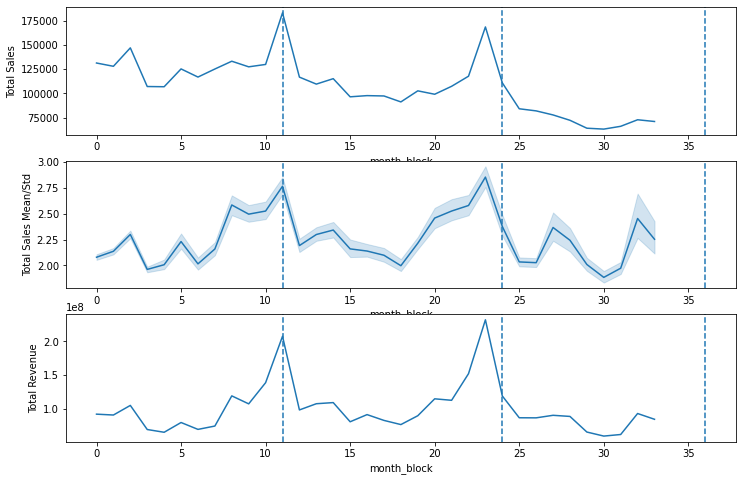

In [34]:
train_monthly_company_sales_df = train_monthly_df.groupby(["month_block"]).agg({"item_cnt": "sum", "item_revenue": "sum"})

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
sns.lineplot(x="month_block", y="item_cnt", data=train_monthly_company_sales_df, ax=ax[0])
ax[0].axvline(11, 0, 3, linestyle="--")
ax[0].axvline(24, 0, 3, linestyle="--")
ax[0].axvline(36, 0, 3, linestyle="--")
ax[0].set_ylabel("Total Sales")

sns.lineplot(x="month_block", y="item_cnt", data=train_monthly_df, ax=ax[1])
ax[1].axvline(11, 0, 3, linestyle="--")
ax[1].axvline(24, 0, 3, linestyle="--")
ax[1].axvline(36, 0, 3, linestyle="--")
ax[1].set_ylabel("Total Sales Mean/Std")

sns.lineplot(x="month_block", y="item_revenue", data=train_monthly_company_sales_df, ax=ax[2])
ax[2].axvline(11, 0, 3, linestyle="--")
ax[2].axvline(24, 0, 3, linestyle="--")
ax[2].axvline(36, 0, 3, linestyle="--")
ax[2].set_ylabel("Total Revenue")

## Sales for the Whole Company (Overlaid)

Text(0, 0.5, 'Total Revenue')

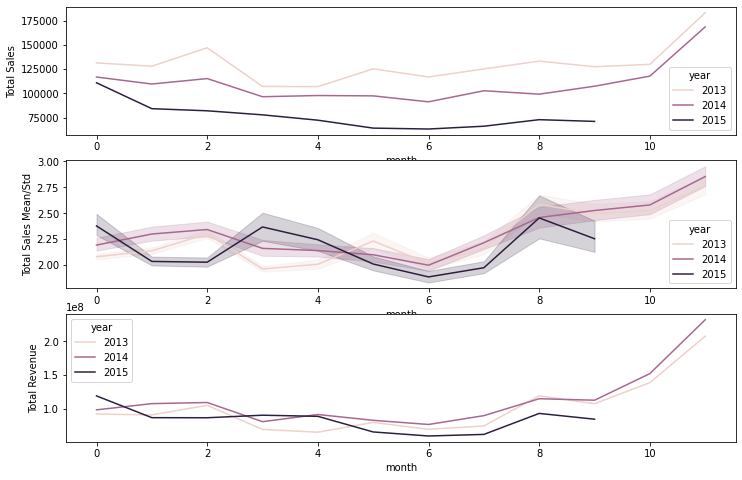

In [35]:
train_monthly_company_sales_df = train_monthly_df.groupby(["year", "month"]).agg({"item_cnt": "sum", "item_revenue": "sum"})
train_monthly_company_sales_df.head()

fig, ax = plt.subplots(3, 1, figsize=(12, 8))
sns.lineplot(x="month", y="item_cnt", hue="year", data=train_monthly_company_sales_df, ax=ax[0])
ax[0].set_ylabel("Total Sales")

sns.lineplot(x="month", y="item_cnt", hue="year", data=train_monthly_df, ax=ax[1])
ax[1].set_ylabel("Total Sales Mean/Std")

sns.lineplot(x="month", y="item_revenue", hue="year", data=train_monthly_company_sales_df, ax=ax[2])
ax[2].set_ylabel("Total Revenue")

## Item Prices 

Text(0, 0.5, 'Total Item Prices Median')

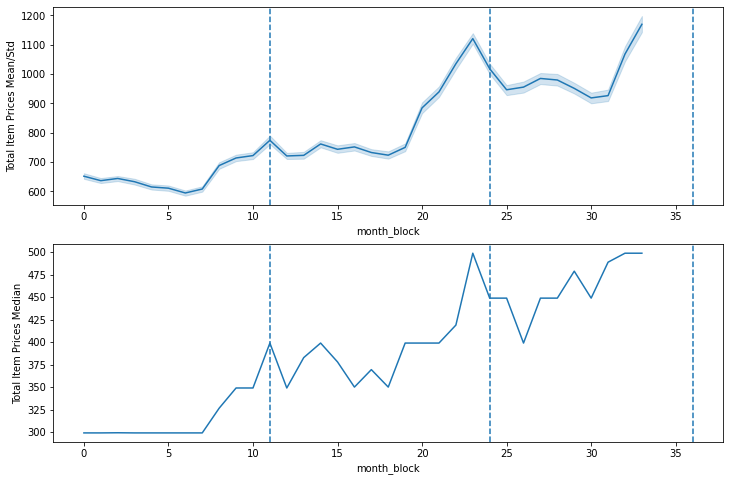

In [36]:
train_median_item_prices = train_monthly_df.groupby(["month_block"], as_index=False).agg({"mean_item_price": ["median"]})
train_median_item_prices.columns = ["month_block", "median_item_price"]

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
sns.lineplot(x="month_block", y="mean_item_price", data=train_monthly_df, ax=ax[0])
ax[0].axvline(11, 0, 3, linestyle="--")
ax[0].axvline(24, 0, 3, linestyle="--")
ax[0].axvline(36, 0, 3, linestyle="--")
ax[0].set_ylabel("Total Item Prices Mean/Std")

sns.lineplot(x="month_block", y="median_item_price", data=train_median_item_prices, ax=ax[1])
ax[1].axvline(11, 0, 3, linestyle="--")
ax[1].axvline(24, 0, 3, linestyle="--")
ax[1].axvline(36, 0, 3, linestyle="--")
ax[1].set_ylabel("Total Item Prices Median")

# Category Level

## What Category Sales More ?

In [37]:
def fill_missing_categories(df: pd.DataFrame, all_possible_categories: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_categories = set(df["item_category_id"].unique())
    missing_categories = all_possible_categories - df_categories
    new_rows = []
    for missing_category_id in missing_categories:
        new_rows.append(
            (year, missing_category_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "item_category_id", "item_cnt"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [38]:
train_categories_sales_df = train_monthly_df.groupby(["year", "item_category_id"], as_index=False).agg({"item_cnt": ["sum"]})
train_categories_sales_df.columns = ["year", "item_category_id", "item_cnt"]

categories_year_2013 = train_categories_sales_df[train_categories_sales_df["year"] == 2013]
categories_year_2014 = train_categories_sales_df[train_categories_sales_df["year"] == 2014]
categories_year_2015 = train_categories_sales_df[train_categories_sales_df["year"] == 2015]

all_possible_categories = set(categories_year_2013["item_category_id"].unique()).union(set(categories_year_2014["item_category_id"].unique())).union(set(categories_year_2015["item_category_id"].unique()))
categories_year_2013 = fill_missing_categories(categories_year_2013, all_possible_categories)
categories_year_2014 = fill_missing_categories(categories_year_2014, all_possible_categories)
categories_year_2015 = fill_missing_categories(categories_year_2015, all_possible_categories)

[(0.0, 330990.0)]

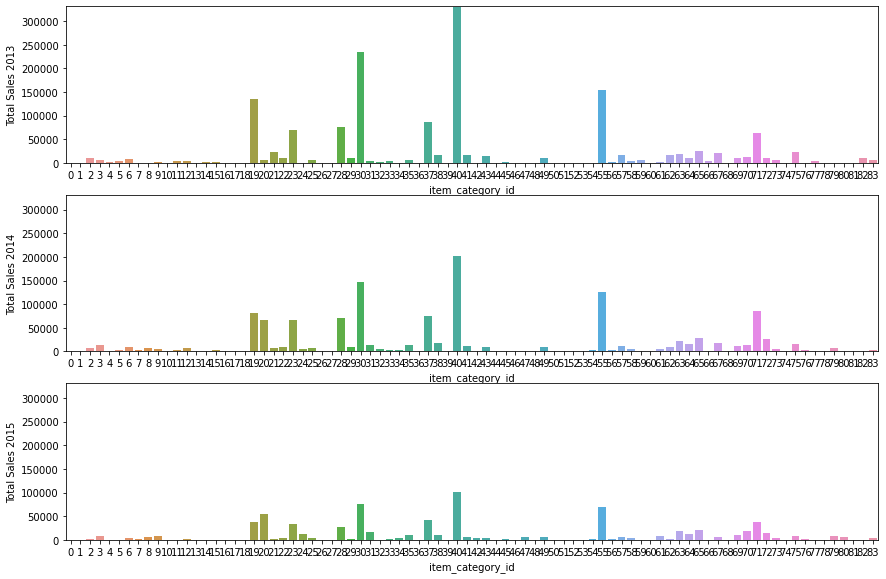

In [39]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="item_category_id", y="item_cnt", data=categories_year_2013, ax=ax[0])
ax[0].set_ylabel("Total Sales 2013")
ax[0].set(ylim=(0, train_categories_sales_df["item_cnt"].max() + 100))
sns.barplot(x="item_category_id", y="item_cnt", data=categories_year_2014, ax=ax[1])
ax[1].set_ylabel("Total Sales 2014")
ax[1].set(ylim=(0, train_categories_sales_df["item_cnt"].max() + 100))
sns.barplot(x="item_category_id", y="item_cnt", data=categories_year_2015, ax=ax[2])
ax[2].set_ylabel("Total Sales 2015")
ax[2].set(ylim=(0, train_categories_sales_df["item_cnt"].max() + 100))

# Number of Items / Category

In [40]:
def fill_missing_categories(df: pd.DataFrame, all_possible_categories: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_categories = set(df["item_category_id"].unique())
    missing_categories = all_possible_categories - df_categories
    new_rows = []
    for missing_category_id in missing_categories:
        new_rows.append(
            (year, missing_category_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "item_category_id", "num_items"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [41]:
train_number_items_df = train_monthly_df.groupby(["year", "item_category_id"], as_index=False).agg({"item_id": ["count"]})
train_number_items_df.columns = ["year", "item_category_id", "num_items"]

categories_year_2013 = train_number_items_df[train_number_items_df["year"] == 2013]
categories_year_2014 = train_number_items_df[train_number_items_df["year"] == 2014]
categories_year_2015 = train_number_items_df[train_number_items_df["year"] == 2015]

all_possible_categories = set(categories_year_2013["item_category_id"].unique()).union(set(categories_year_2014["item_category_id"].unique())).union(set(categories_year_2015["item_category_id"].unique()))
categories_year_2013 = fill_missing_categories(categories_year_2013, all_possible_categories)
categories_year_2014 = fill_missing_categories(categories_year_2014, all_possible_categories)
categories_year_2015 = fill_missing_categories(categories_year_2015, all_possible_categories)

[(0.0, 170699.0)]

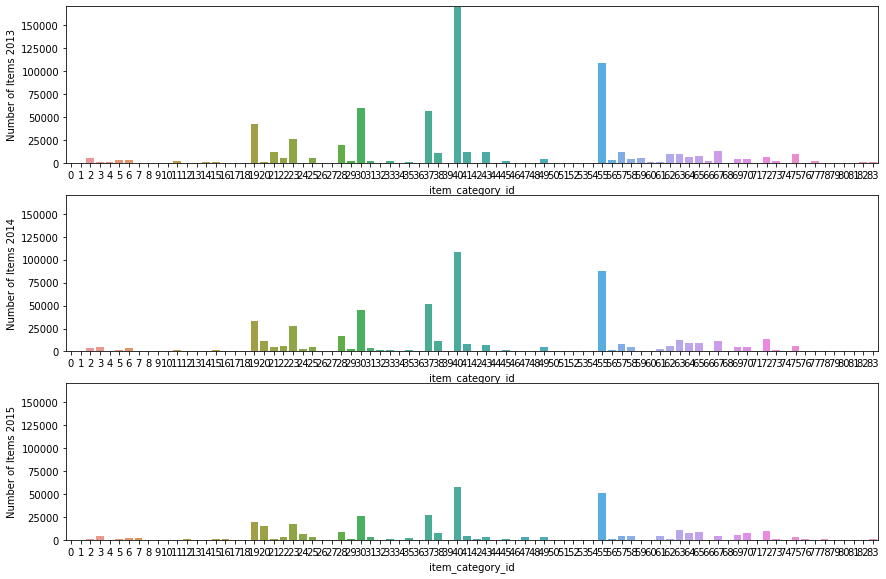

In [42]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="item_category_id", y="num_items", data=categories_year_2013, ax=ax[0])
ax[0].set_ylabel("Number of Items 2013")
ax[0].set(ylim=(0, train_number_items_df["num_items"].max() + 100))
sns.barplot(x="item_category_id", y="num_items", data=categories_year_2014, ax=ax[1])
ax[1].set_ylabel("Number of Items 2014")
ax[1].set(ylim=(0, train_number_items_df["num_items"].max() + 100))
sns.barplot(x="item_category_id", y="num_items", data=categories_year_2015, ax=ax[2])
ax[2].set_ylabel("Number of Items 2015")
ax[2].set(ylim=(0, train_number_items_df["num_items"].max() + 100))

# City Level

## What City Sells more?

In [43]:
def fill_missing_cities(df: pd.DataFrame, all_possible_cities: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_cities = set(df["city_id"].unique())
    missing_cities = all_possible_cities - df_cities
    new_rows = []
    for missing_city_id in missing_cities:
        new_rows.append(
            (year, missing_city_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "city_id", "item_cnt"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [44]:
train_city_sales_df = train_monthly_df.groupby(["year", "city_id"], as_index=False).agg({"item_cnt": ["sum"]})
train_city_sales_df.columns = ["year", "city_id", "item_cnt"]

city_year_2013 = train_city_sales_df[train_city_sales_df["year"] == 2013]
city_year_2014 = train_city_sales_df[train_city_sales_df["year"] == 2014]
city_year_2015 = train_city_sales_df[train_city_sales_df["year"] == 2015]

all_possible_cities = set(city_year_2013["city_id"].unique()).union(set(city_year_2014["city_id"].unique())).union(set(city_year_2015["city_id"].unique()))
city_year_2013 = fill_missing_cities(city_year_2013, all_possible_cities)
city_year_2014 = fill_missing_cities(city_year_2014, all_possible_cities)
city_year_2015 = fill_missing_cities(city_year_2015, all_possible_cities)

[(0.0, 560440.0)]

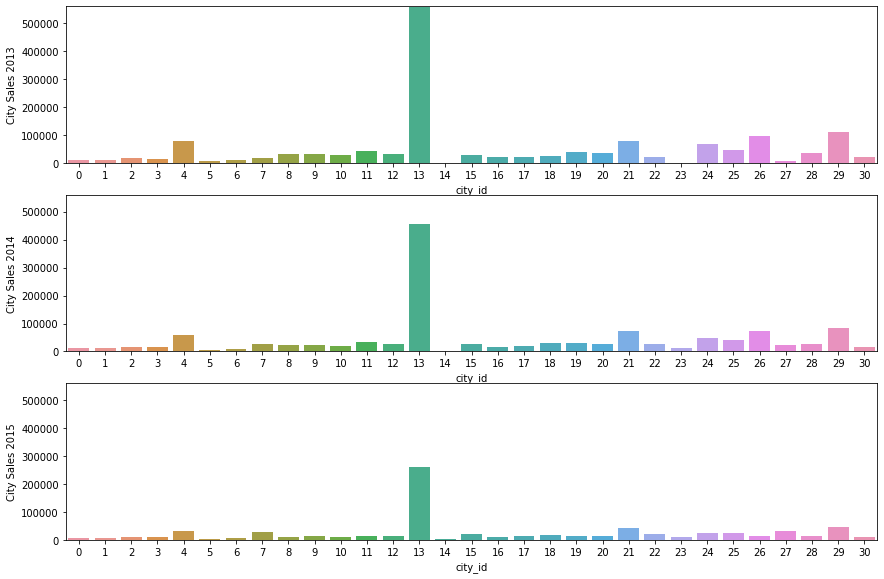

In [45]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="city_id", y="item_cnt", data=city_year_2013, ax=ax[0])
ax[0].set_ylabel("City Sales 2013")
ax[0].set(ylim=(0, train_city_sales_df["item_cnt"].max() + 100))
sns.barplot(x="city_id", y="item_cnt", data=city_year_2014, ax=ax[1])
ax[1].set_ylabel("City Sales 2014")
ax[1].set(ylim=(0, train_city_sales_df["item_cnt"].max() + 100))
sns.barplot(x="city_id", y="item_cnt", data=city_year_2015, ax=ax[2])
ax[2].set_ylabel("City Sales 2015")
ax[2].set(ylim=(0, train_city_sales_df["item_cnt"].max() + 100))

## Number of Items / City

In [46]:
def fill_missing_cities(df: pd.DataFrame, all_possible_cities: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_cities = set(df["city_id"].unique())
    missing_cities = all_possible_cities - df_cities
    new_rows = []
    for missing_city_id in missing_cities:
        new_rows.append(
            (year, missing_city_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "city_id", "num_items"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [47]:
train_city_sales_df = train_monthly_df.groupby(["year", "city_id"], as_index=False).agg({"item_id": ["count"]})
train_city_sales_df.columns = ["year", "city_id", "num_items"]

city_year_2013 = train_city_sales_df[train_city_sales_df["year"] == 2013]
city_year_2014 = train_city_sales_df[train_city_sales_df["year"] == 2014]
city_year_2015 = train_city_sales_df[train_city_sales_df["year"] == 2015]

all_possible_cities = set(city_year_2013["city_id"].unique()).union(set(city_year_2014["city_id"].unique())).union(set(city_year_2015["city_id"].unique()))
city_year_2013 = fill_missing_cities(city_year_2013, all_possible_cities)
city_year_2014 = fill_missing_cities(city_year_2014, all_possible_cities)
city_year_2015 = fill_missing_cities(city_year_2015, all_possible_cities)

[(0.0, 218417.0)]

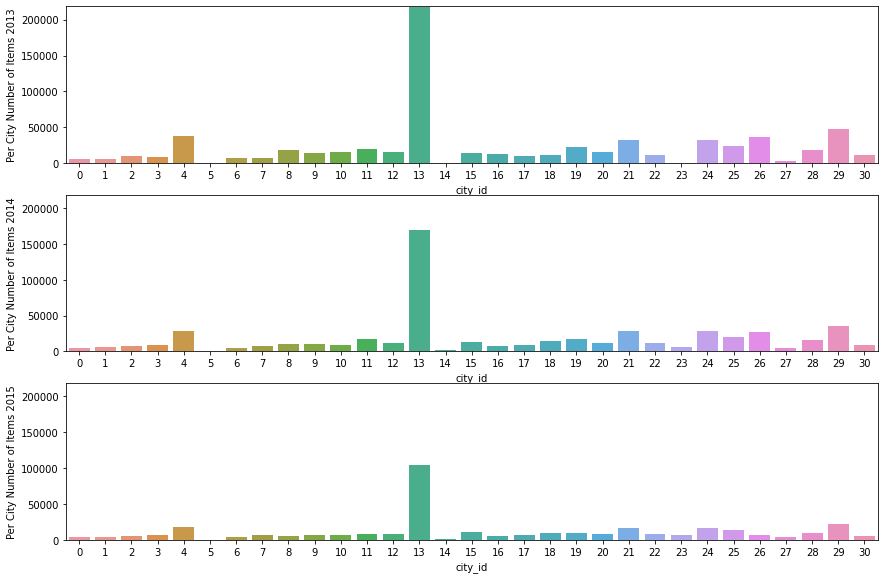

In [48]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="city_id", y="num_items", data=city_year_2013, ax=ax[0])
ax[0].set_ylabel("Per City Number of Items 2013")
ax[0].set(ylim=(0, train_city_sales_df["num_items"].max() + 100))
sns.barplot(x="city_id", y="num_items", data=city_year_2014, ax=ax[1])
ax[1].set_ylabel("Per City Number of Items 2014")
ax[1].set(ylim=(0, train_city_sales_df["num_items"].max() + 100))
sns.barplot(x="city_id", y="num_items", data=city_year_2015, ax=ax[2])
ax[2].set_ylabel("Per City Number of Items 2015")
ax[2].set(ylim=(0, train_city_sales_df["num_items"].max() + 100))

# Shop Level 

## What Shop Sells More?

In [49]:
def fill_missing_shops(df: pd.DataFrame, all_shop_ids: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_shop_ids = set(df["shop_id"].unique())
    missing_shop_ids = all_shop_ids - df_shop_ids
    new_rows = []
    for missing_shop_id in missing_shop_ids:
        new_rows.append(
            (year, missing_shop_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "shop_id", "num_items"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [50]:
train_shop_sales_df = train_monthly_df.groupby(["year", "shop_id"], as_index=False).agg({"item_cnt": ["sum"], "item_revenue": ["sum"]})
train_shop_sales_df.columns = ["year", "shop_id", "item_cnt", "item_revenue"]

shops_year_2013 = train_shop_sales_df[train_shop_sales_df["year"] == 2013]
shops_year_2014 = train_shop_sales_df[train_shop_sales_df["year"] == 2014]
shops_year_2015 = train_shop_sales_df[train_shop_sales_df["year"] == 2015]

all_possible_shop_ids = set(shops_year_2013["shop_id"].unique()).union(set(shops_year_2014["shop_id"].unique())).union(set(shops_year_2015["shop_id"].unique()))
shops_year_2013 = fill_missing_shops(shops_year_2013, all_possible_shop_ids)
shops_year_2014 = fill_missing_shops(shops_year_2014, all_possible_shop_ids)
shops_year_2015 = fill_missing_shops(shops_year_2015, all_possible_shop_ids)

[(0.0, 132587.0)]

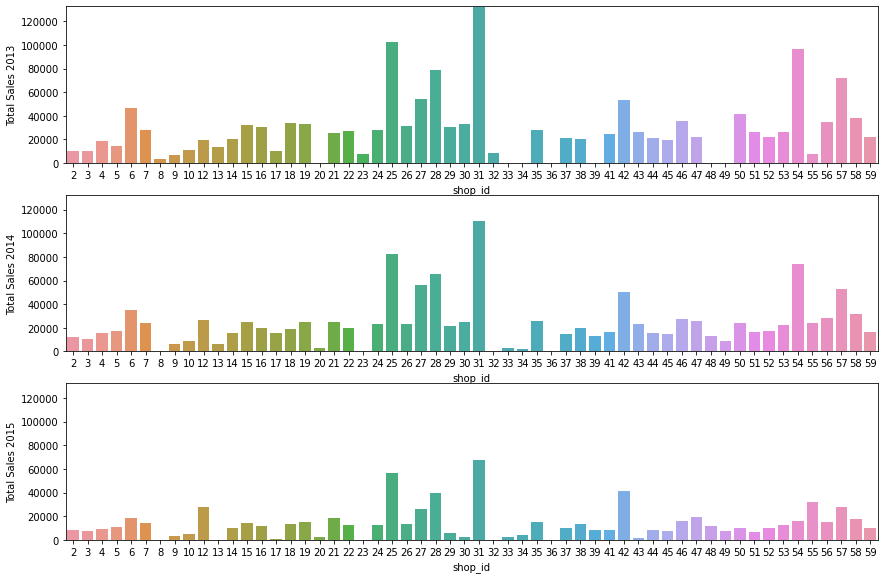

In [51]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="shop_id", y="item_cnt", data=shops_year_2013, ax=ax[0])
ax[0].set_ylabel("Total Sales 2013")
ax[0].set(ylim=(0, train_shop_sales_df["item_cnt"].max() + 100))
sns.barplot(x="shop_id", y="item_cnt", data=shops_year_2014, ax=ax[1])
ax[1].set_ylabel("Total Sales 2014")
ax[1].set(ylim=(0, train_shop_sales_df["item_cnt"].max() + 100))
sns.barplot(x="shop_id", y="item_cnt", data=shops_year_2015, ax=ax[2])
ax[2].set_ylabel("Total Sales 2015")
ax[2].set(ylim=(0, train_shop_sales_df["item_cnt"].max() + 100))

## Number of Items / Shop

In [52]:
def fill_missing_shops(df: pd.DataFrame, all_shop_ids: set) -> pd.DataFrame:
    year_df = df["year"].unique()
    assert len(year_df) == 1, "Function not supporting multiple years."
    year = year_df[0]
    
    df_shop_ids = set(df["shop_id"].unique())
    missing_shop_ids = all_shop_ids - df_shop_ids
    new_rows = []
    for missing_shop_id in missing_shop_ids:
        new_rows.append(
            (year, missing_shop_id, 0)
        )
    new_df = pd.DataFrame(columns=["year", "shop_id", "num_items"], data=new_rows)
    df = pd.concat([df, new_df])
    
    return df

In [53]:
train_shop_sales_df = train_monthly_df.groupby(["year", "shop_id"], as_index=False).agg({"item_cnt": ["count"]})
train_shop_sales_df.columns = ["year", "shop_id", "num_items"]

shops_year_2013 = train_shop_sales_df[train_shop_sales_df["year"] == 2013]
shops_year_2014 = train_shop_sales_df[train_shop_sales_df["year"] == 2014]
shops_year_2015 = train_shop_sales_df[train_shop_sales_df["year"] == 2015]

all_possible_shop_ids = set(shops_year_2013["shop_id"].unique()).union(set(shops_year_2014["shop_id"].unique())).union(set(shops_year_2015["shop_id"].unique()))
shops_year_2013 = fill_missing_shops(shops_year_2013, all_possible_shop_ids)
shops_year_2014 = fill_missing_shops(shops_year_2014, all_possible_shop_ids)
shops_year_2015 = fill_missing_shops(shops_year_2015, all_possible_shop_ids)

[(0.0, 41129.0)]

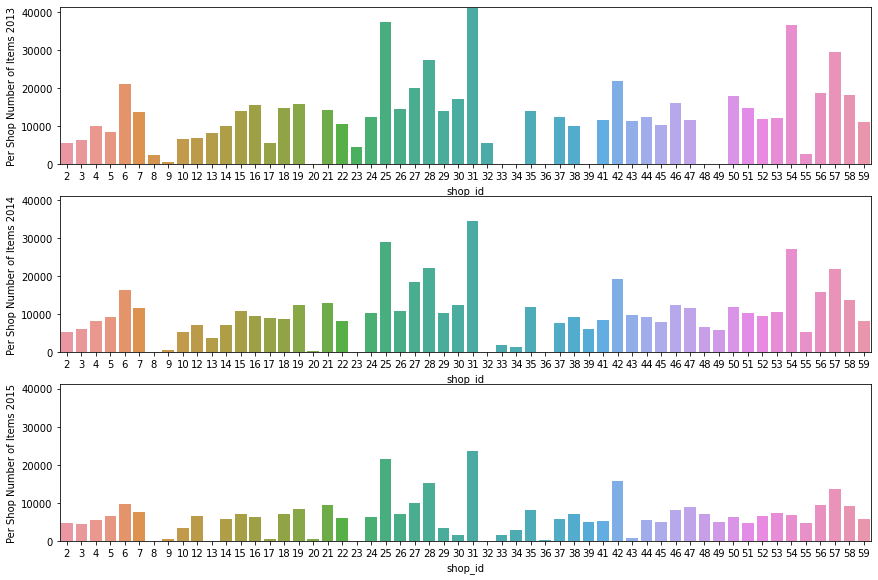

In [54]:
fig, ax = plt.subplots(3, 1, figsize=(12, 8))
fig.tight_layout()

sns.barplot(x="shop_id", y="num_items", data=shops_year_2013, ax=ax[0])
ax[0].set_ylabel("Per Shop Number of Items 2013")
ax[0].set(ylim=(0, train_shop_sales_df["num_items"].max() + 100))
sns.barplot(x="shop_id", y="num_items", data=shops_year_2014, ax=ax[1])
ax[1].set_ylabel("Per Shop Number of Items 2014")
ax[1].set(ylim=(0, train_shop_sales_df["num_items"].max() + 100))
sns.barplot(x="shop_id", y="num_items", data=shops_year_2015, ax=ax[2])
ax[2].set_ylabel("Per Shop Number of Items 2015")
ax[2].set(ylim=(0, train_shop_sales_df["num_items"].max() + 100))

## Prices Distribution for a Store

In [55]:
def plot_prices_distribution_store(df: pd.DataFrame, shop_id: int):
    df = df.copy()
    df = df.query(f"shop_id == {shop_id}")
    
    fig, axes = plt.subplots(1, 1, figsize=(14, 8))
    sns.histplot(x=df["item_price"])

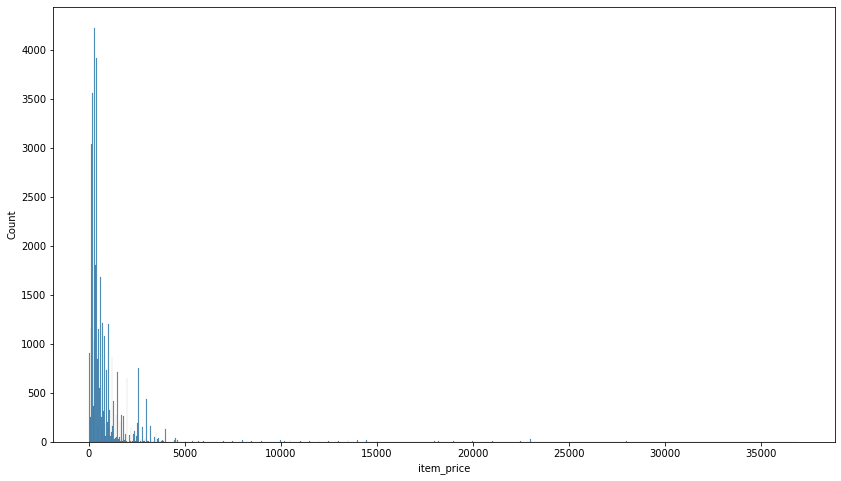

In [56]:
plot_prices_distribution_store(train_df, shop_id=5)

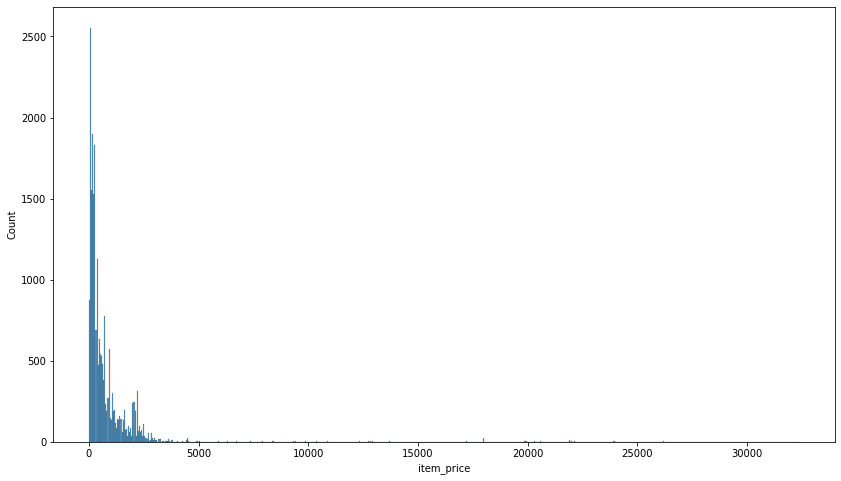

In [57]:
plot_prices_distribution_store(train_df, shop_id=10)

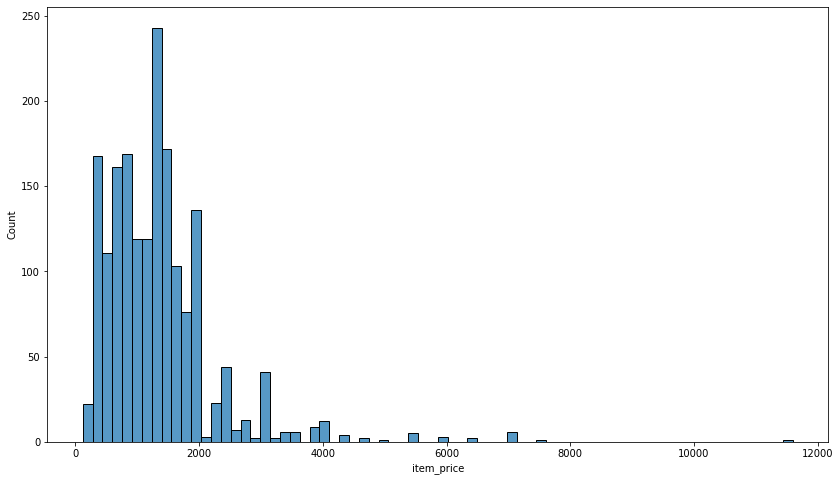

In [58]:
plot_prices_distribution_store(train_df, shop_id=20)

## Same Item Different Stores

In [59]:
def plot_item_for_different_stores(df: pd.DataFrame, item_id: int):
    df = df.copy()
    df = df.query(f"item_id == {item_id}")
    df = df.groupby(["date", "shop_id", "item_id"], as_index=False).agg({"item_price": ["mean"]})
    df.columns = ["date", "shop_id", "item_id", "item_price"]
    
    fig = sns.lineplot(x=df["date"], y=df["item_price"], hue=df["shop_id"])
    plt.tight_layout() 

In [60]:
shop_counts_df = train_df.groupby("item_id").agg({"shop_id":["count"]})
shop_counts_df.columns = ["count"]
shop_counts_df[shop_counts_df["count"] >= 30000]

,count
item_id,
20949,31340


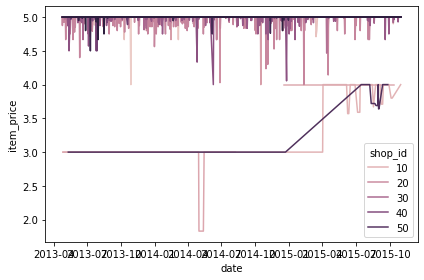

In [61]:
plot_item_for_different_stores(train_df, item_id=20949)

In [62]:
def compare_cheaper_vs_expensive_item(df: pd.DataFrame, item_id: int):
    df = df.copy()
    df = df.query(f"item_id == {item_id}")
    day_groups = df.groupby("date")
    min_df = pd.DataFrame(columns=["date", "item_price", "item_cnt_day"])
    max_df = pd.DataFrame(columns=["date", "item_price", "item_cnt_day"])
    for name, day_group in day_groups:
        min_price_row_id = day_group["item_price"].idxmin()
        max_price_row_id = day_group["item_price"].idxmax()
        
        min_price_total_sales = day_group.loc[min_price_row_id, ["date", "item_price", "item_cnt_day"]]
        min_df = pd.concat([min_df, min_price_total_sales.to_frame().T], axis=0)
        max_price_total_sales = day_group.loc[max_price_row_id, ["date", "item_price", "item_cnt_day"]]
        max_df = pd.concat([max_df, max_price_total_sales.to_frame().T], axis=0)
        
    min_df = min_df.sort_values(by=["date"])
    max_df = max_df.sort_values(by=["date"])

    sns.scatterplot(x=min_df["item_cnt_day"], y=min_df["item_price"], color="b")
    sns.scatterplot(x=max_df["item_cnt_day"], y=max_df["item_price"], color="r")
    plt.legend(labels=["Min prices", "Max prices"])
    plt.plot()

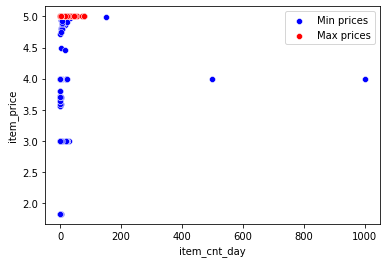

In [63]:
compare_cheaper_vs_expensive_item(train_df, item_id=20949)

## Decomposition

In [64]:
def decompose(df: pd.DataFrame, shop_id: int, plot_default: bool = False):
    """
        df: DataFrame with a daily frequency
    """
    
    all_months = df["month_block"]
    all_months =range(all_months.min(), all_months.max())
    df = df[df["shop_id"] == shop_id]
    df = df.groupby(["month_block"]).sum()
    
    # Reindex the time series so the 1D frequency is consistent.
    df = df.reindex(all_months)
    df = df.fillna(0)
    
    old_figsize = rcParams["figure.figsize"]
    rcParams["figure.figsize"] = 12, 10
    
    stl = STL(df["item_cnt"], robust=False, period=2, seasonal=7, seasonal_deg=1, trend_deg=1, low_pass_deg=1)
    res = stl.fit()
    fig = res.plot()
    if plot_default is True:
        second_stl = STL(df["item_cnt"], period=2)
        second_stl = second_stl.fit()
        add_stl_plot(fig, second_stl, legend=["Custom", "Default"])
    
    rcParams["figure.figsize"] = old_figsize
    

def add_stl_plot(fig, res, legend):
    """Add 3 plots from a second STL fit"""
    axs = fig.get_axes()
    comps = ["trend", "seasonal", "resid"]
    for ax, comp in zip(axs[1:], comps):
        series = getattr(res, comp)
        if comp == "resid":
            ax.plot(series, marker="o", linestyle="none")
        else:
            ax.plot(series)
            if comp == "trend":
                ax.legend(legend, frameon=False)

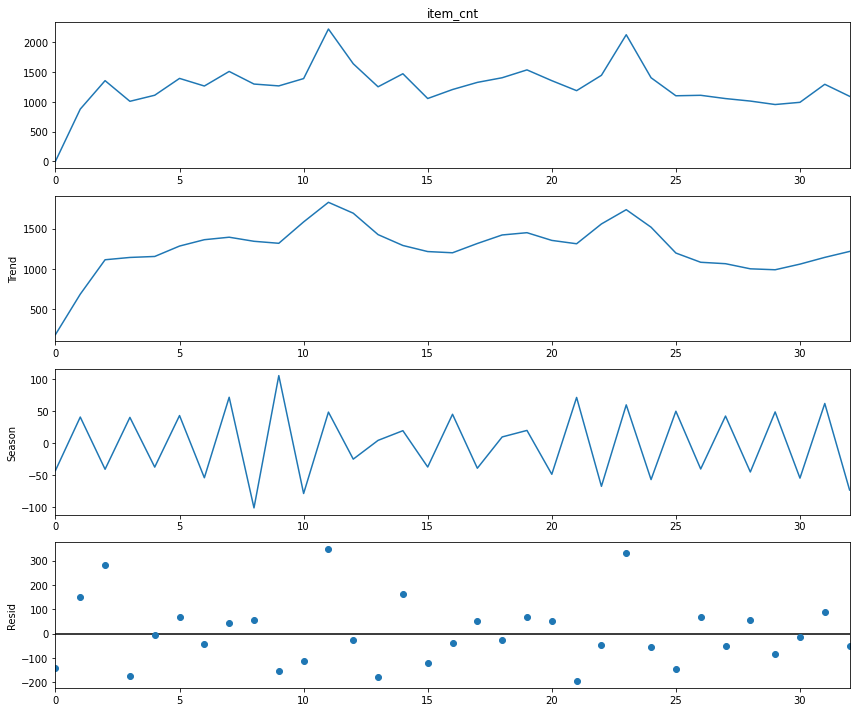

In [65]:
decompose(train_monthly_df, shop_id=5)

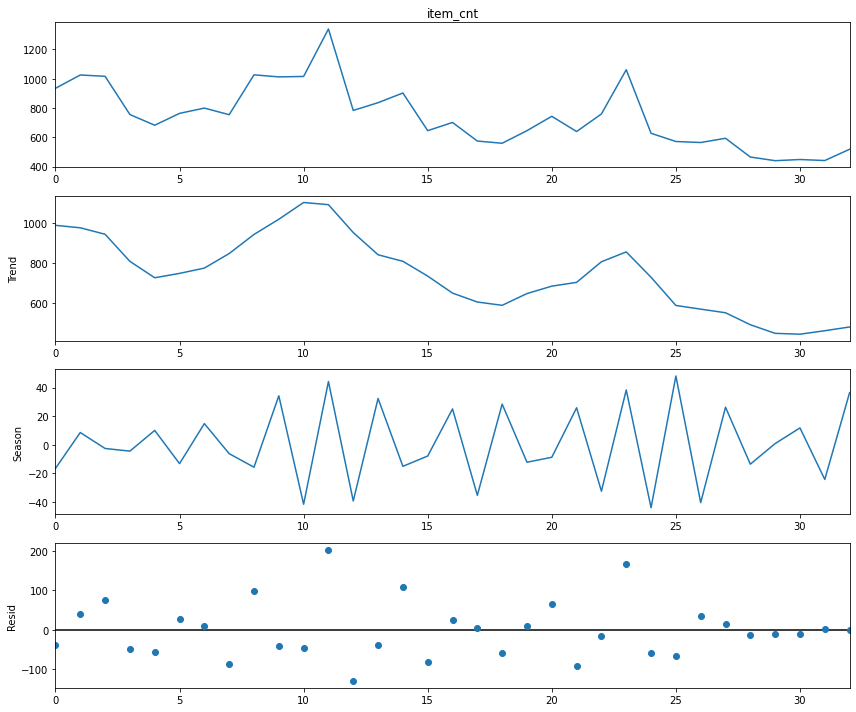

In [66]:
decompose(train_monthly_df, shop_id=10)

# Correlation

In [67]:
def correlation_matrix(df: pd.DataFrame, columns: List[str], shop_id: int):
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
    
    df = df.copy()
    df = df[df["shop_id"] == shop_id]
    df = df.groupby("date").sum()
    df = df.sort_index()
    matrix = df[columns].corr(method="pearson")
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
    plt.show()

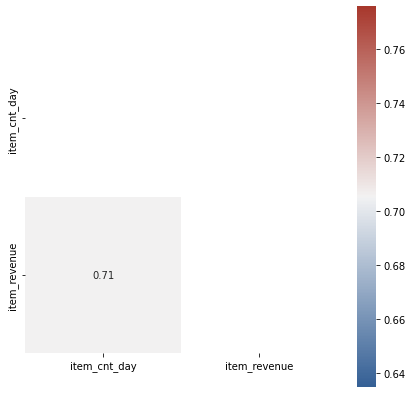

In [68]:
correlation_matrix(train_df, columns=["item_cnt_day", "item_revenue"], shop_id=5)

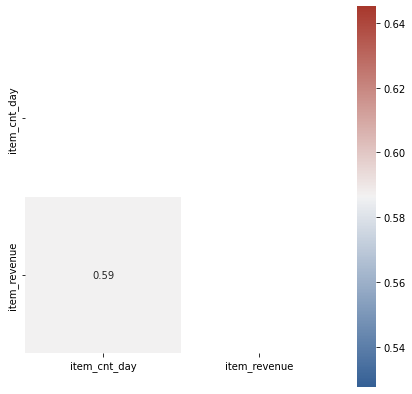

In [69]:
correlation_matrix(train_df, columns=["item_cnt_day", "item_revenue"], shop_id=10)

## Autocorrelation

In [70]:
def autocorrelation(df: pd.DataFrame, shop_id: int, month_lags: int = 18, print_from: int = 30):
    df = df.copy()
    df = df[df["shop_id"] == shop_id]
    df = df.groupby("date").sum()
    df = df.sort_index()
    
    assert len(df) > 0
    
    # correlation_plot(df["item_cnt_day"])
    
    corr, sign = sm.tsa.stattools.acf(df["item_cnt_day"], nlags=30*month_lags, alpha=0.05, missing="raise")
    corr = corr[print_from:]
    sign = sign[print_from:] 
    points = [(t + print_from, t_corr, t_sign) for t, (t_corr, t_sign) in enumerate(zip(corr, sign))]
    points = [(t, t_corr, t_sign) for t, t_corr, t_sign in points if t_corr > t_sign[0] - t_corr or t_corr < t_sign[1] - t_corr]
    points = sorted(points,key=lambda p: max(abs(p[1] - (p[2][0] - p[1])), abs(p[1] - (p[2][1] - p[1]))), reverse=True)
    print("Most important lags that have statistical significance:")
    for p in points[:10]:
        print(p)
    
    fig, axes = plt.subplots(2,1,figsize=(12,10))
    sm.graphics.tsa.plot_acf(df["item_cnt_day"], lags=30*month_lags, ax=axes[0])
    axes[0].set_title(f"Daily Item Sales Autocorrelation for ~{month_lags} Months")
    sm.graphics.tsa.plot_acf(df["item_revenue"], lags=30*month_lags, ax=axes[1])
    axes[1].set_title(f"Daily Revenue Autocorrelation for ~{month_lags} Month")

    
def correlation_plot(d, dt=6e-3, **kwargs):
    corr, conf = sm.tsa.stattools.acf(d, nlags=len(d)-1, alpha=0.05)
    taus = dt*np.arange(0, len(d))
    ax = plt.gca()
    ax.plot(taus, corr, **kwargs)
    ax.fill_between(taus, y1=conf[:,0] - corr, y2=conf[:,1] - corr, color='g', alpha=0.2, lw=0)
    ax.set_xscale('log')
    ax.set_xlabel(r'$\tau$ (seconds)')
    ax.set_ylabel(r'$G(\tau)$')
    ax.grid()

Most important lags that have statistical significance:
(364, 0.3525790493377992, array([0.12427103, 0.58088707]))
(357, 0.2806747213020392, array([0.05505718, 0.50629226]))
(371, 0.2602935708335019, array([0.02804258, 0.49254456]))
(365, 0.2603735225257548, array([0.02997503, 0.49077202]))
(56, 0.32958844676411725, array([0.19533153, 0.46384537]))
(350, 0.21563878449844393, array([-0.00837136,  0.43964893]))
(363, 0.21182641441718164, array([-0.01572233,  0.43937516]))
(372, 0.19346075725497305, array([-0.03991266,  0.42683417]))
(322, 0.20529227367722047, array([-0.01330823,  0.42389278]))
(63, 0.2816976547263555, array([0.14206598, 0.42132933]))


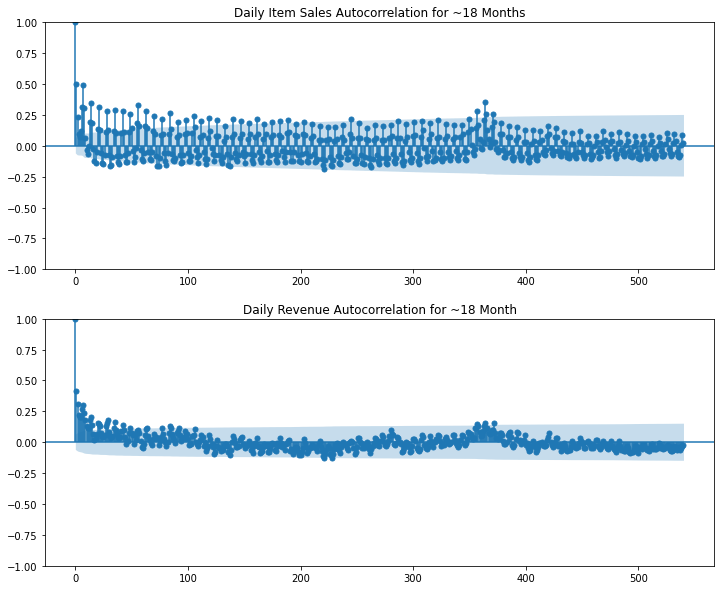

In [71]:
autocorrelation(train_df, shop_id=5)

Most important lags that have statistical significance:
(42, 0.2668745078346362, array([0.13448124, 0.39926778]))
(56, 0.20584942400703837, array([0.06360853, 0.34809032]))
(35, 0.2215125857780323, array([0.09554321, 0.34748196]))
(83, 0.18999307990068176, array([0.03581341, 0.34417275]))
(62, 0.1932418568564932, array([0.04764802, 0.33883569]))
(55, 0.19727518506834854, array([0.0560594 , 0.33849097]))
(362, 0.14730204401436892, array([-0.0278336 ,  0.32243768]))
(84, 0.16672074995169858, array([0.01166951, 0.32177199]))
(76, 0.16970056821256668, array([0.01826324, 0.32113789]))
(104, 0.15542011584204257, array([-0.00611111,  0.31695134]))


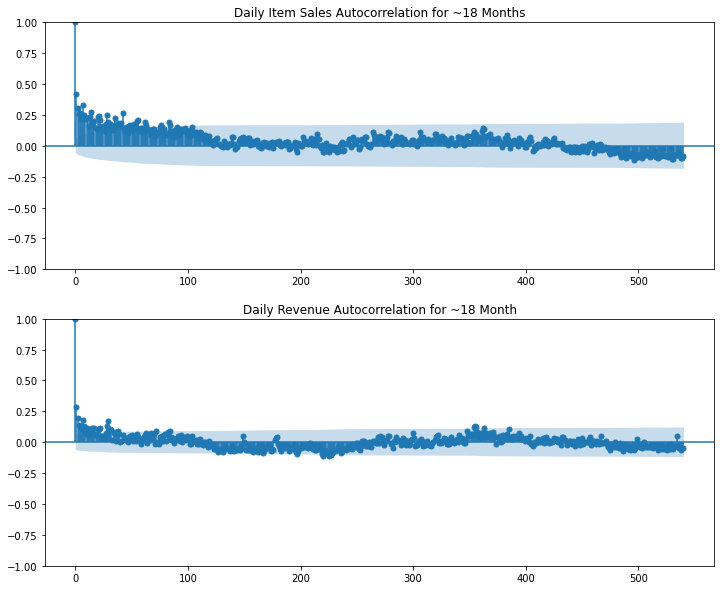

In [72]:
autocorrelation(train_df, shop_id=10)

## Moving Averages

In [73]:
def plot_moving_averages(df: pd.DataFrame, shop_id: int):
    df = df.copy()
    df = df.query(f"shop_id == {shop_id}")
    df = df.groupby("date", as_index=False).sum()
    print(f"Length original df = {len(df)}")
    
    date_range = pd.date_range(start=df["date"].min(), end=df["date"].max(), freq="1D")
    df_empty = pd.DataFrame(index=date_range, columns=[])
    df_empty = df_empty.reset_index()
    df_empty.columns = ["date"]
    df = df_empty.merge(df, on=["date"], how="left")
    print(f"Length padded df = {len(df)}")
    
    # df[df["date"].isin(date_range[100:200])] = np.nan
    nan_indexes = [index for index, row in df.iterrows() if row.isnull().any()]
    df["item_cnt_day_ema_14"] = df["item_cnt_day"].ewm(span=14, adjust=True, ignore_na=True).mean()
    df["item_cnt_day_ema_30"] = df["item_cnt_day"].ewm(span=30, adjust=True, ignore_na=True).mean()
    df["item_cnt_day_std_14"] = df["item_cnt_day"].ewm(span=14, adjust=True, ignore_na=True).std()
    df["item_cnt_day_std_30"] = df["item_cnt_day"].ewm(span=30, adjust=True, ignore_na=True).std()
    df["item_revenue_ema_14"] = df["item_revenue"].ewm(span=14, adjust=True, ignore_na=True).mean()
    df["item_revenue_ema_30"] = df["item_revenue"].ewm(span=30, adjust=True, ignore_na=True).mean()
    df["item_revenue_std_14"] = df["item_revenue"].ewm(span=14, adjust=True, ignore_na=True).std()
    df["item_revenue_std_30"] = df["item_revenue"].ewm(span=30, adjust=True, ignore_na=True).std()
    df.loc[nan_indexes] = np.nan
    
    fig, axes = plt.subplots(2, 1, figsize=(18, 10))
    axes[0].plot(df.index, df["item_cnt_day"], label="Item Sales")
    axes[0].plot(df.index, df["item_cnt_day_ema_14"], label="Item Sales EMA 14")
    axes[0].plot(df.index, df["item_cnt_day_ema_30"], label="Item Sales EMA 30")
    axes[0].plot(df.index, df["item_cnt_day_std_14"], label="Item Sales STD 14")
    axes[0].plot(df.index, df["item_cnt_day_std_30"], label="Item Sales STD 30")
    axes[0].set_ylabel(f"Item Sales for Shop {shop_id}")
    axes[1].plot(df.index, df["item_revenue"], label="Item Revenue")
    axes[1].plot(df.index, df["item_revenue_ema_14"], label="Item Revenue EMA 14")
    axes[1].plot(df.index, df["item_revenue_ema_30"], label="Item Revenue EMA 30")
    axes[1].plot(df.index, df["item_revenue_std_14"], label="Item Revenue STD 14")
    axes[1].plot(df.index, df["item_revenue_std_30"], label="Item Revenue STD 30")
    axes[1].set_ylabel(f"Item Revenue for Shop {shop_id}")
    plt.legend()

Length original df = 996
Length padded df = 996


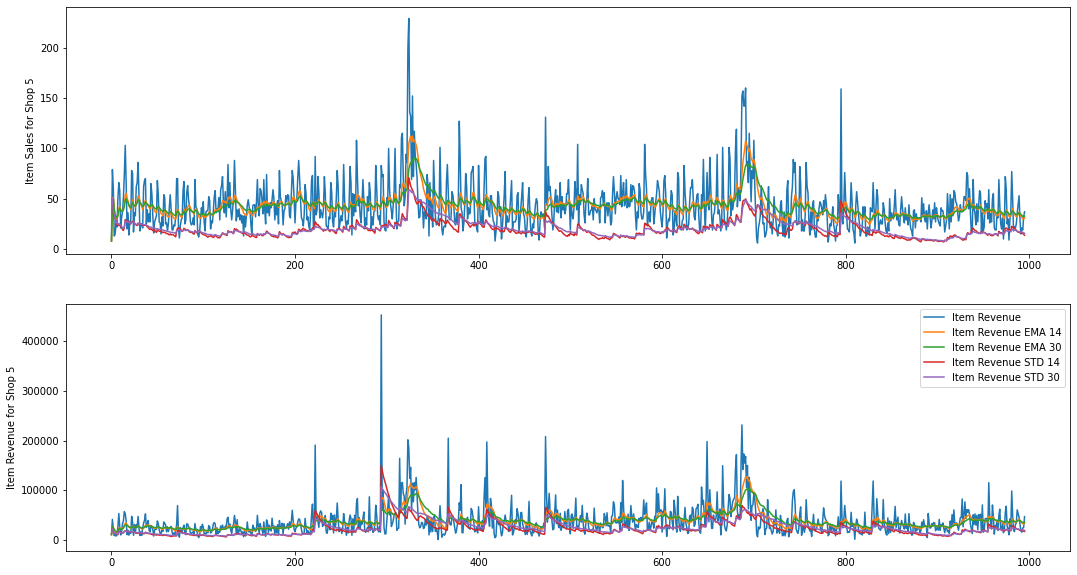

In [74]:
plot_moving_averages(train_df, shop_id=5)

Length original df = 1029
Length padded df = 1033


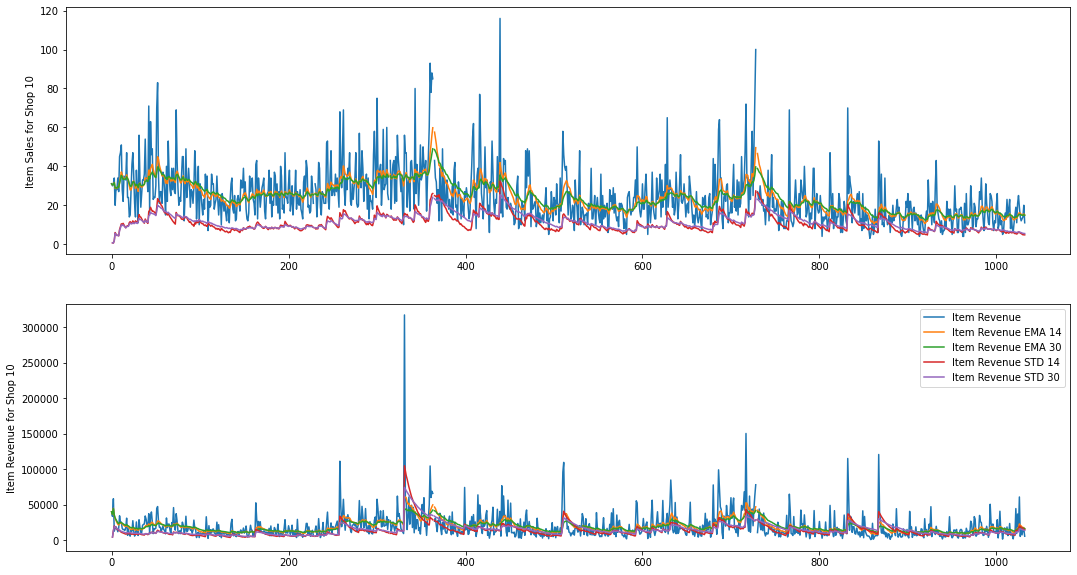

In [75]:
plot_moving_averages(train_df, shop_id=10)

Length original df = 1012
Length padded df = 1033


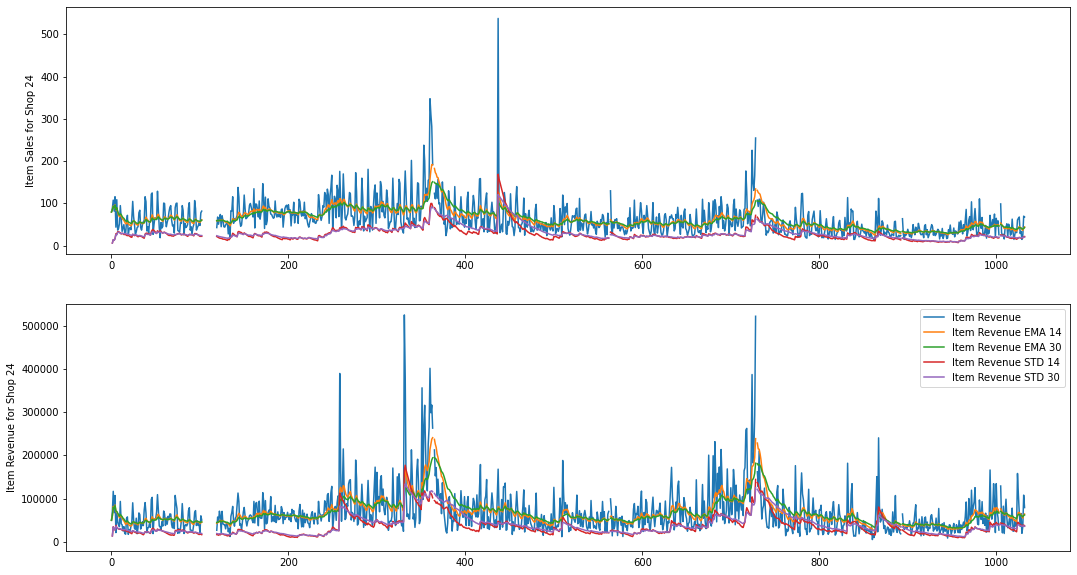

In [76]:
plot_moving_averages(train_df, shop_id=24)

# Item Level

## Item Sales & Transactions

In [77]:
def plot_all_items_for_shop(df: pd.DataFrame, shop_id: int):
    df = df.query(f"shop_id == {shop_id}")
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    sns.lineplot(x=df["month_block"], y=df["item_cnt"], hue=df["item_id"], ax=axes[0])
    axes[0].set_ylabel("Sales")
    sns.lineplot(x=df["month_block"], y=df["transactions"], hue=df["item_id"], ax=axes[1])
    axes[1].set_ylabel("Transactions")

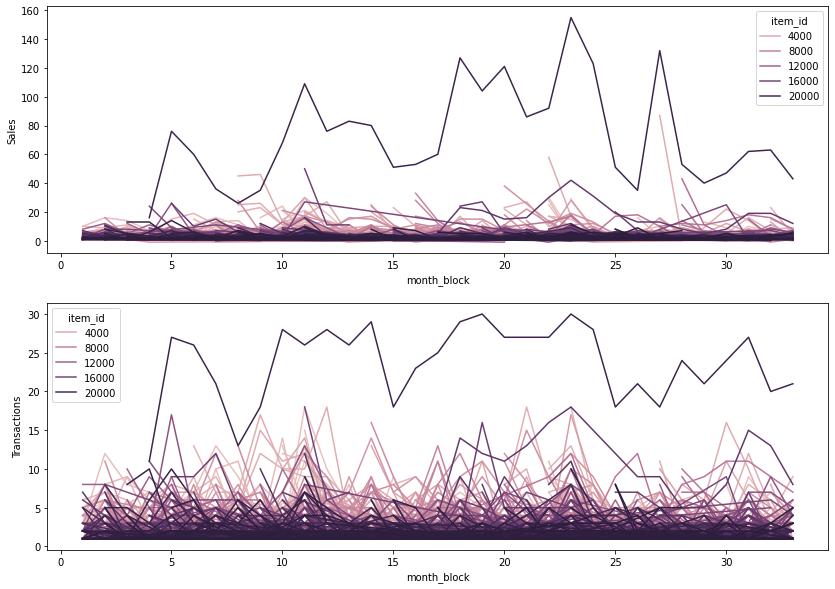

In [78]:
plot_all_items_for_shop(train_monthly_df, shop_id=5)

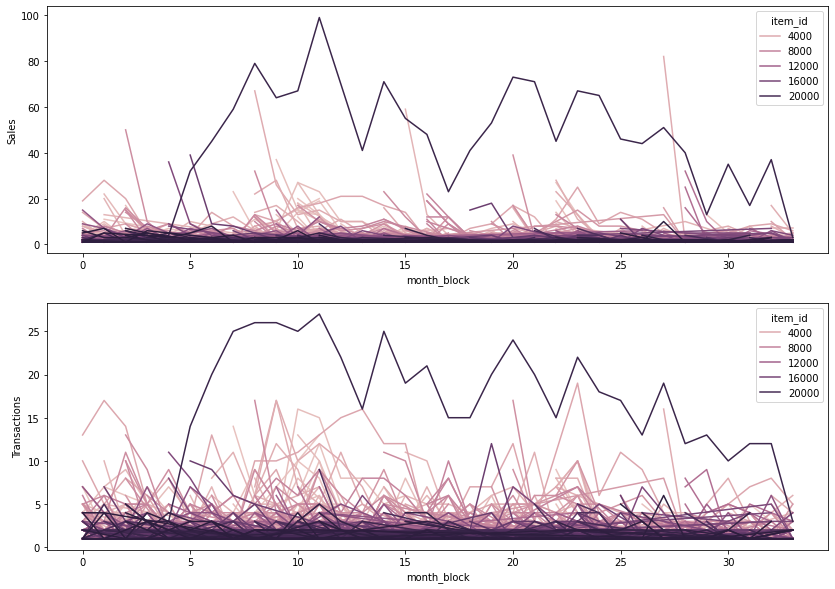

In [79]:
plot_all_items_for_shop(train_monthly_df, shop_id=10)

## Correlation Sales / Prices

In [80]:
def item_correlation_matrix(df: pd.DataFrame, shop_id: int, item_id: int):
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
    
    df = df.copy()
    df = df.query(f"shop_id == {shop_id} and item_id == {item_id}")
    df = df.groupby("date").mean()
    matrix = df[["item_cnt_day", "item_price"]].corr(method="pearson")
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
    plt.show()
    
    
def raw_correlation_matrix(df: pd.DataFrame):
    cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)
    
    matrix = df[["item_cnt_day", "item_price"]].corr(method="pearson")
    mask = np.triu(np.ones_like(matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(7, 7))
    sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
    plt.show()

### Filtered Item Correlation

In [81]:
df = train_df.query("shop_id == 5").groupby("item_id", as_index=False).agg({"date": ["count"]})
df.columns = ["item_id", "count"]
df.max()

item_id    22167
count        711
dtype: int64

In [82]:
df[df["count"] == 711]

,item_id,count
6744,20949,711


In [83]:
train_df.query("shop_id == 5 and item_id == 20949")

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,city_name,city_id,city_coord_1,city_coord_2,country_part,item_revenue
531159,2013-05-02,4,5,20949,5.0,1.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Вологда ТРЦ ""Мармелад""",вологда,3,59.2239,39.88398,2,5.0
531116,2013-05-06,4,5,20949,5.0,1.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Вологда ТРЦ ""Мармелад""",вологда,3,59.2239,39.88398,2,5.0
531114,2013-05-10,4,5,20949,5.0,2.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Вологда ТРЦ ""Мармелад""",вологда,3,59.2239,39.88398,2,10.0
531090,2013-05-12,4,5,20949,5.0,1.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Вологда ТРЦ ""Мармелад""",вологда,3,59.2239,39.88398,2,5.0
531089,2013-05-16,4,5,20949,5.0,1.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Вологда ТРЦ ""Мармелад""",вологда,3,59.2239,39.88398,2,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915952,2015-10-21,33,5,20949,5.0,2.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Вологда ТРЦ ""Мармелад""",вологда,3,59.2239,39.88398,2,10.0
2915953,2015-10-22,33,5,20949,5.0,1.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Вологда ТРЦ ""Мармелад""",вологда,3,59.2239,39.88398,2,5.0
2915954,2015-10-23,33,5,20949,5.0,1.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Вологда ТРЦ ""Мармелад""",вологда,3,59.2239,39.88398,2,5.0
2915955,2015-10-28,33,5,20949,5.0,1.0,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Вологда ТРЦ ""Мармелад""",вологда,3,59.2239,39.88398,2,5.0


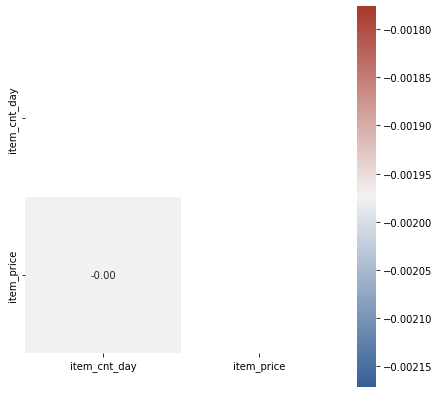

In [84]:
item_correlation_matrix(train_df, shop_id=5, item_id=20949)

### Raw Correlation

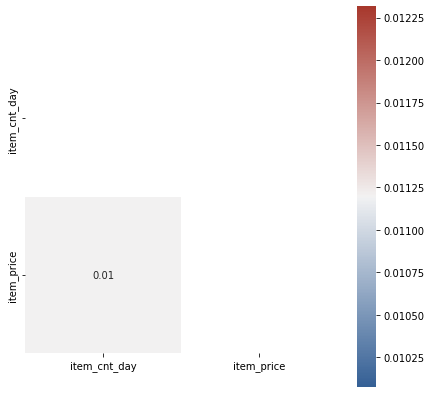

In [85]:
raw_correlation_matrix(train_df)

## Item Price

In [86]:
def plot_item_price(df: pd.DataFrame, item_id: int):
    df = df.query(f"item_id == {item_id}")
    df = df.groupby(["date", "item_id"], as_index=False).agg({"item_price": ["mean"], "item_cnt_day": ["sum"]})
    df.columns = ["date", "item_id", "item_price", "item_cnt_day"]
    
    fig, axes = plt.subplots(2, 1, figsize=(14,8))
    fig.suptitle(f"Item {item_id} across all shops", fontsize=12)
    sns.lineplot(x=df["date"], y=df["item_price"], ax=axes[0])
    axes[0].set_ylabel(f"Item Price")
    sns.barplot(x=df["date"], y=df["item_cnt_day"], ax=axes[1])
    axes[1].set_ylabel(f"Item Sales")

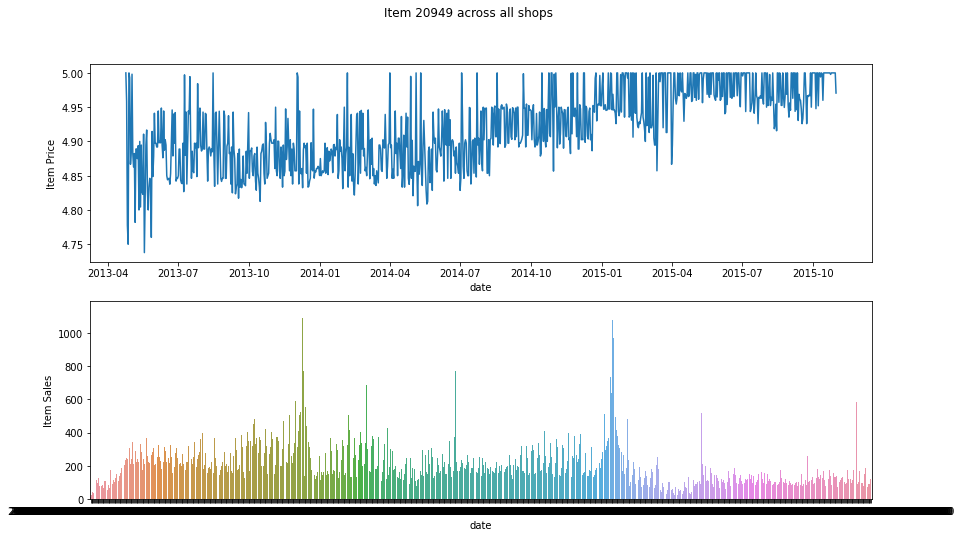

In [87]:
plot_item_price(train_df, 20949)

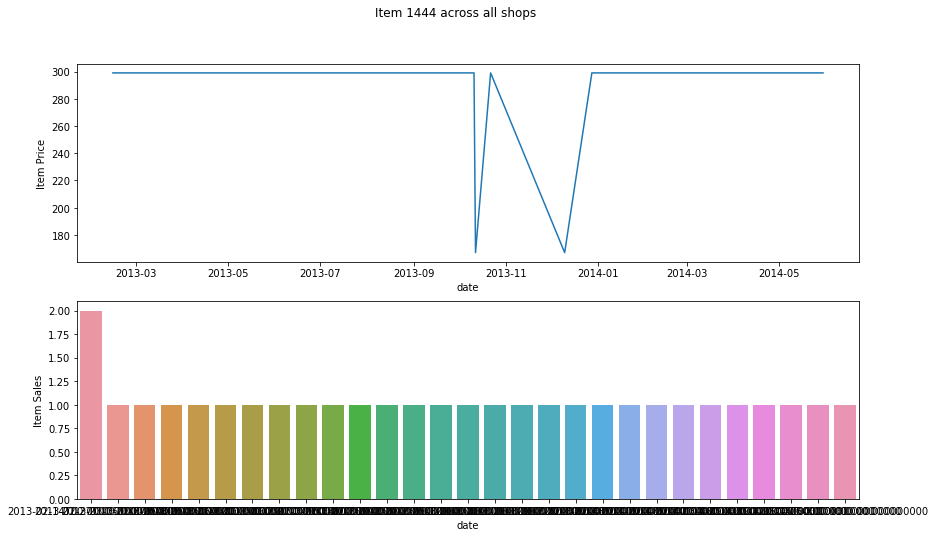

In [88]:
plot_item_price(train_df, 1444)

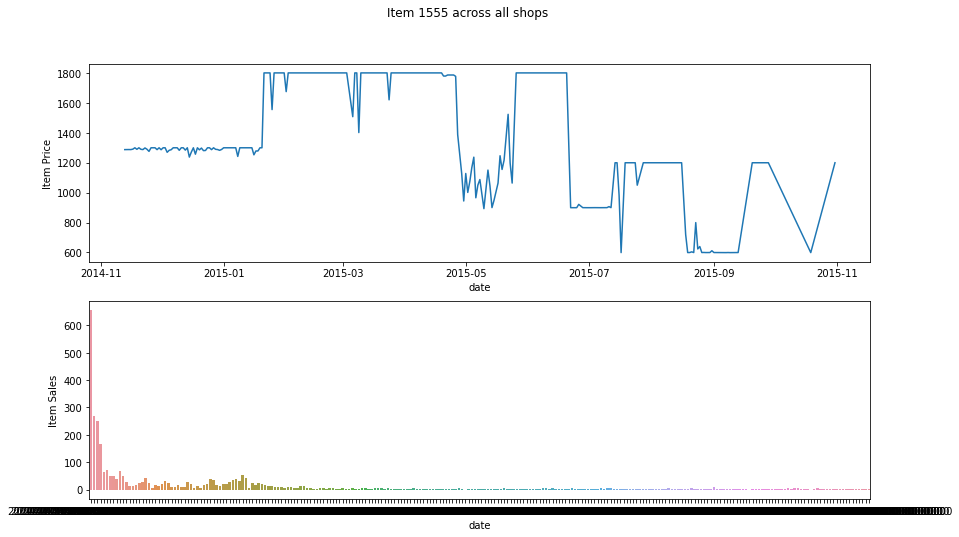

In [89]:
plot_item_price(train_df, 1555)

## Autocorrelation

In [90]:
def item_autocorrelation(df: pd.DataFrame, shop_id: int, item_id: int, month_lags: int = 22, print_from: int = 30):
    df = df.copy()
    df = df.query(f"shop_id == {shop_id} and item_id == {item_id}")
    df = df.groupby("date").sum()
    df = df.sort_index()
    
    assert len(df) > 0
    
    corr, sign = sm.tsa.stattools.acf(df["item_cnt_day"], nlags=30*month_lags, alpha=0.05, missing="raise")
    corr = corr[print_from:]
    sign = sign[print_from:] 
    points = [(t + print_from, t_corr, t_sign) for t, (t_corr, t_sign) in enumerate(zip(corr, sign))]
    points = [(t, t_corr, t_sign) for t, t_corr, t_sign in points if t_corr > t_sign[0] - t_corr or t_corr < t_sign[1] - t_corr]
    points = sorted(points,key=lambda p: max(abs(p[1] - (p[2][0] - p[1])), abs(p[1] - (p[2][1] - p[1]))), reverse=True)
    print("Most important lags that have statistical significance:")
    for p in points[:10]:
        print(p)
    
    fig, axes = plt.subplots(2,1,figsize=(12,10))
    sm.graphics.tsa.plot_acf(df["item_cnt_day"], lags=30*month_lags, ax=axes[0])
    axes[0].set_title(f"Daily Item Sales Autocorrelation for ~{month_lags} Months")
    sm.graphics.tsa.plot_acf(df["item_revenue"], lags=30*month_lags, ax=axes[1])
    axes[1].set_title(f"Daily Revenue Autocorrelation for ~{month_lags} Month")

Most important lags that have statistical significance:
(243, 0.2670596247653006, array([0.17977706, 0.35434219]))
(174, 0.23822892343291077, array([0.15667242, 0.31978543]))
(65, 0.18435558968580187, array([0.109631  , 0.25908018]))
(69, 0.1328190308930246, array([0.05553709, 0.21010098]))
(178, 0.1134103366266853, array([0.02811956, 0.19870112]))
(109, 0.0926269321748273, array([0.01299941, 0.17225445]))
(396, 0.052466683944274964, array([-0.04106554,  0.14599891]))
(332, 0.04748676505505568, array([-0.0452275 ,  0.14020103]))
(117, 0.0560942035870193, array([-0.02426949,  0.13645789]))
(244, -0.037975812817225195, array([-0.12956689,  0.05361526]))


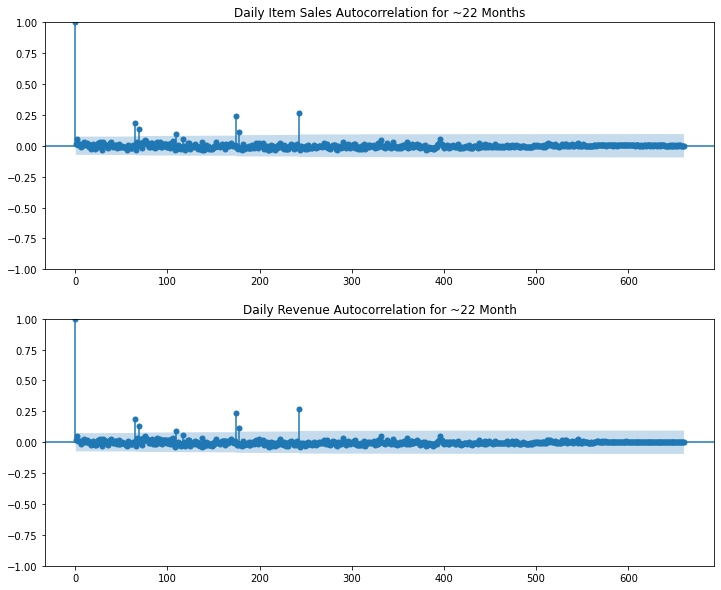

In [91]:
item_autocorrelation(train_df, shop_id=5, item_id=20949)

## Decomposition

In [92]:
def decompose(df: pd.DataFrame, shop_id: int, item_id: int):
    """
        df: DataFrame with a daily frequency
    """
    
    df = df.copy()
    df = df.query(f"shop_id == {shop_id} and item_id == {item_id}")
    df = df.query(f"item_cnt >= 0")
    
    all_months = df["month_block"]
    all_months =range(all_months.min(), all_months.max())
    df = df.groupby(["month_block"]).sum()
    # Reindex the time series so the 1D frequency is consistent.
    df = df.reindex(all_months)
    df = df.fillna(0)
    
    old_figsize = rcParams["figure.figsize"]
    rcParams["figure.figsize"] = 12, 10
    
    stl = STL(df["item_cnt"], robust=True, period=2, seasonal=7, seasonal_deg=1, trend_deg=1, low_pass_deg=1)
    res = stl.fit()
    fig = res.plot()
    
    rcParams["figure.figsize"] = old_figsize

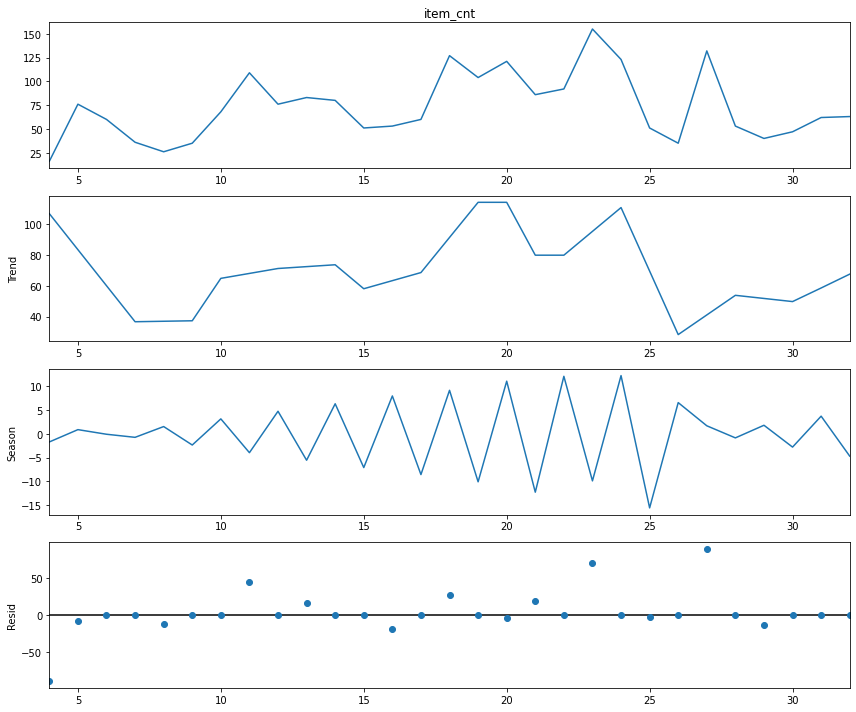

In [93]:
decompose(train_monthly_df, shop_id=5, item_id=20949)